## Whole Genome Sequenced Mycobacterium bovis analysis for BTBgenie.

Note: the current version of the M.bovis genome online has genes missing in the annotation. See https://www.ncbi.nlm.nih.gov/nuccore/LT708304.1?report=graph

Updated files can be found here: https://github.com/dmnfarrell/gordon-group/tree/master/mbovis_annotation

links:

* https://github.com/JosephCrispell/GeneralTools/tree/master/ProcessingPipeline
* [Woodchester Park eLife paper](https://elifesciences.org/articles/45833)
* [An African origin for Mycobacterium bovis](https://academic.oup.com/emph/article/2020/1/49/5719036)
* http://www.htslib.org/doc/bcftools.html
* https://mtbgenomicsworkshop.readthedocs.io/
* [BCFtools cheat sheet](https://gist.github.com/elowy01/93922762e131d7abd3c7e8e166a74a0b)
* https://biopython.org/wiki/Category:Cookbook
* https://pyvcf.readthedocs.io/en/v0.4.6/INTRO.html

In [1]:
import sys,os,shutil,subprocess
import random
import glob, time
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from gzip import open as gzopen
sys.path.append('pathogenie')
from snpgenie import tools, aligners, app, trees, plotting

## Mbovis samples from SRA

In [2]:
sra = pd.read_csv('../sra_mbovis_runtable.csv')

## Get master table with Loiseau et al. meta data¶

In [3]:
df = pd.read_excel('../Loiseau_TableS1.xlsx')
master = pd.merge(df,sra,left_on='BIOSAMPLE',right_on='BioSample',how='inner')
master.to_csv('../mbovis_sra_master.csv',index=False)
cols = ['Run','CLONAL_COMPLEX','COUNTRY_ISOLATION','LibraryLayout','Host','ReleaseDate','Bytes','Bases','GENOME_COVERAGE']
#master.columns
#master.geo_loc_name_country.value_counts()

## Representative samples of lineages

In [46]:
sub=master[(master.LibraryLayout=='PAIRED') & (master.COUNTRY_ISOLATION.notnull()) & (master.CLONAL_COMPLEX=='Eu2')]
#print (sub[cols])
#sub[cols].to_csv('../temp.csv')
accessions=['SRR1792002','SRR5216872','SRR5486071','ERR841808','ERR125601',
            'SRR8063654','SRR8063665','SRR8065079','SRR1791768','SRR1791960','ERR2815558']
testset = master[master.Run.isin(accessions)]
print (testset[cols])

             Run CLONAL_COMPLEX COUNTRY_ISOLATION LibraryLayout        Host           ReleaseDate        Bytes        Bases  GENOME_COVERAGE
36     ERR841808            Eu1                UK        PAIRED         Cow  2015-12-02T00:00:00Z  130651179.0  196040478.0            39.78
245   SRR5216872            Eu1       New Zealand        PAIRED      BOVINE  2017-01-31T00:00:00Z  194523112.0  295803584.0            41.39
464   SRR5486071       Unknown2          Ethiopia        PAIRED  Bos taurus  2017-04-28T00:00:00Z  251875435.0  445066100.0            50.71
677    ERR125601            Eu1           Ireland        PAIRED         NaN  2012-10-01T00:00:00Z  277182504.0  346340680.0            68.83
765   ERR2815558            Af1               NaN        PAIRED         NaN  2018-09-29T00:00:00Z  162711425.0  367702705.0            67.64
886   SRR1791768            Eu2            Canada        PAIRED      Cattle  2015-03-11T00:00:00Z  340596851.0  450406275.0            37.69
1076  SRR1791

In [186]:
# fetch from SRA
def fetch_sra_reads(df,path):
    """download a subset of reads """
    
    for i,r in df.iterrows():
        files = glob.glob(os.path.join(path,r.Run+'*'))        
        if len(files)==0:
            cmd = 'fastq-dump --split-files {n} --outdir {o}'.format(n=r.Run,o=path)
            print (cmd)
            subprocess.check_output(cmd,shell=True)

fetch_sra_reads(testset,path='/storage/btbgenie/mbovis_sra')

fastq-dump --split-files SRR1791960 --outdir /storage/btbgenie/mbovis_sra


## Blasting to known contaminants

* https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-2684-x#Sec2

In [32]:
#get unmapped reads from a bam file

infile='mapped/3_S57_L001.bam'
cmd = 'samtools view -b -f 4 {i} > unmapped.bam'.format(i=infile)
print (cmd)
#align with bwa to known index of contaminants


samtools view -b -f 4 mapped/3_S57_L001.bam > unmapped.bam


## Examine FASTQ file quality and define trimming parameters

In [ ]:
reload(tools)

df = tools.fastq_to_dataframe(testfile)
df.length.hist()

In [ ]:
def trim_reads_default(filename, outfile, right_quality=30):
    """Trim adapters"""
        
    fastq_parser = SeqIO.parse(gzopen(filename, "rt"), "fastq")
    c=0
    out = gzopen(outfile, "wt")
    for record in fastq_parser:
        score = record.letter_annotations["phred_quality"]         
        for i in range(len(score)-1,0,-1):
            if score[i] >= right_quality:
                break
        #trimmed.append(record[:i])
        #print (record[:i])        
        #c+=1
        #if c>100:
        #    break    
        SeqIO.write(record[:i],out,'fastq')
    return

testfile = 'mbovis_sra/SRR1791711_1.fastq.gz'
st=time.time()
trim_reads_default(testfile,'trimmed.fastq.gz')
print (time.time()-st)
df = tools.fastq_to_dataframe('trimmed.fastq.gz')
df.length.hist()

## multiprocess trimming

In [439]:
def split_fastq(filename, chunks=4):
    """Split fastq file"""
    
    names=[]
    tmp = '/tmp'
    tmpfiles = []
    record_iter = SeqIO.parse(gzopen(filename, "rt"), "fastq")
    length = 
    for i, batch in enumerate(tools.batch_iterator(record_iter, chunksize)):
        tempfile = "group_%i.fastq" % (i + 1)
        tmpfiles.append(tempfile)
        names.append(tempfile)
        with open(tempfile, "w") as handle:
            count = SeqIO.write(batch, handle, "fastq")
        print("Wrote %i records to %s" % (count, tempfile))
    return names

split_fastq(testfile)

Wrote 465388 records to group_1.fastq


['group_1.fastq']

In [ ]:
tools.plot_fastq_qualities(testfile,limit=100000)
plt.savefig('fastq_quals.png',dpi=100)
tools.plot_fastq_gc_content(testfile, limit=50000)
plt.savefig('gc.png',dpi=100)

## Get sample ids from fastq files

In [333]:
path1='/storage/btbgenie/albania'
files = glob.glob(os.path.join(path1,'*.fastq.gz'))
path2='/storage/btbgenie/mbovis_sra'
files = glob.glob(os.path.join(path2,'*.fastq.gz'))
#add outgroup file
#files.append
files = app.get_files_from_paths([path1])

df = app.get_samples(files)
df

['/storage/btbgenie/albania/6_S7_L001-4_R1_001.fastq.gz', '/storage/btbgenie/albania/6_S7_L001-4_R2_001.fastq.gz', '/storage/btbgenie/albania/3_S57_L001-4_R2_001.fastq.gz', '/storage/btbgenie/albania/3_S57_L001-4_R1_001.fastq.gz']


,name,sample,filename,pair
0,3_S57_L001-4_R1_001,3_S57_L001,/storage/btbgenie/albania/3_S57_L001-4_R1_001....,1
1,3_S57_L001-4_R2_001,3_S57_L001,/storage/btbgenie/albania/3_S57_L001-4_R2_001....,2
2,6_S7_L001-4_R1_001,6_S7_L001,/storage/btbgenie/albania/6_S7_L001-4_R1_001.f...,1
3,6_S7_L001-4_R2_001,6_S7_L001,/storage/btbgenie/albania/6_S7_L001-4_R2_001.f...,2


## Align the FASTQ files against reference and create VCF files

In [313]:
reload(aligners)
ref = app.mbovis_genome
samples = app.get_samples(files)
app.align_reads(samples, idx=ref, threads=10, overwrite=False)

bwa mem -M -t 10 /home/damien/.config/snpgenie/genome/Mbovis_AF212297.fa /storage/btbgenie/albania/3_S57_L001-4_R1_001.fastq.gz /storage/btbgenie/albania/3_S57_L001-4_R2_001.fastq.gz | samtools view -F 0x04 -bt - | samtools sort -o mapped/3_S57_L001.bam
samtools index mapped/3_S57_L001.bam
bwa mem -M -t 10 /home/damien/.config/snpgenie/genome/Mbovis_AF212297.fa /storage/btbgenie/albania/6_S7_L001-4_R1_001.fastq.gz /storage/btbgenie/albania/6_S7_L001-4_R2_001.fastq.gz | samtools view -F 0x04 -bt - | samtools sort -o mapped/6_S7_L001.bam
samtools index mapped/6_S7_L001.bam


,name,sample,filename,pair,bam_file
0,3_S57_L001-4_R1_001,3_S57_L001,/storage/btbgenie/albania/3_S57_L001-4_R1_001....,1,mapped/3_S57_L001.bam
1,3_S57_L001-4_R2_001,3_S57_L001,/storage/btbgenie/albania/3_S57_L001-4_R2_001....,2,mapped/3_S57_L001.bam
2,6_S7_L001-4_R1_001,6_S7_L001,/storage/btbgenie/albania/6_S7_L001-4_R1_001.f...,1,mapped/6_S7_L001.bam
3,6_S7_L001-4_R2_001,6_S7_L001,/storage/btbgenie/albania/6_S7_L001-4_R2_001.f...,2,mapped/6_S7_L001.bam


In [16]:
def get_samples():
    import vcf
    vcf_reader = vcf.Reader(open('mapped/calls.vcf.gz', 'rb'))
    vcf_reader.samples

## remove duplicated reads

In [ ]:
cmd = 'samtools rmdup A_reads.bt2.sorted.bam A_reads.bt2.sorted.noDups.bam'

## variant calling

In [346]:
reload(app)
bam_files = glob.glob('mapped/*.bam')
create_bam_labels(bam_files)
st=time.time()
vcf_file = app.variant_calling(bam_files, ref, 'mapped', threads=1, overwrite=True)
print (time.time()-st)

bcftools mpileup -O b --min-MQ 60 -o mapped/raw.bcf -f /home/damien/.config/snpgenie/genome/Mbovis_AF212297.fa mapped/6_S7_L001.bam mapped/3_S57_L001.bam
bcftools call -V indels --ploidy 1 -m -v -o mapped/calls.vcf mapped/raw.bcf
bcftools reheader --samples mapped/samples.txt -o /tmp/calls.vcf mapped/calls.vcf
bcftools filter -i "QUAL>=40 && INFO/DP>=30 && DP4>=4 && MQ>35" -o mapped/filtered.vcf.gz -O z mapped/calls.vcf
110.03333401679993


In [ ]:
v1 = vcf_to_dataframe('result.vcf')
print (v1.var_type.value_counts())

In [ ]:
v2 = vcf_to_dataframe('mapped/raw.bcf')
print (v2.var_type.value_counts())

## filtering
Joe filters: DP - 30, DP4 - 4, MQ - 35, SUP - 0.95 and COV - 0.05. GQ and FQ = 0

In [26]:
cmd = 'bcftools filter -e "QUAL<=40 && DP>=30 && DP4>=4 && MQ>=35" -o filtered.vcf.gz -O z mapped/calls.vcf'
print (cmd)
tmp = subprocess.check_output(cmd,shell=True)
v = vcf_to_dataframe('filtered.vcf.gz')
v.var_type.value_counts()

bcftools filter -e "QUAL<=40 && DP>=30 && DP4>=4 && MQ>=35" -o filtered.vcf.gz -O z mapped/calls.vcf


snp    2804
Name: var_type, dtype: int64

## consequence calling for vcf

In [2]:
reload(app)
ref=app.ref_genome
gff = '../pathogenie/data/Mbovis_csq_format.gff'
out = 'csqout.tsv'
def csq_call():
    cmd = 'bcftools csq -f {r} -g {g} filtered.vcf.gz -Ot -o {o}'.format(r=ref,g=gff,o=out)
    print (cmd)
    tmp = subprocess.check_output(cmd,shell=True)
    
csq_call()

bcftools csq -f /home/damien/.config/pathogenie/genome/Mbovis_AF212297.fa -g ../pathogenie/data/Mbovis_csq_format.gff filtered.vcf.gz -Ot -o csqout.tsv


In [ ]:
reload(app)
def read_csq_file(filename):
    cols = ['1','filename','2','chrom','start','snp_type','gene','locus_tag','strand','feature_type','aa','nuc',]
    csqdf = pd.read_csv(filename,sep='[|\t]',comment='#',names=cols, engine='python')
    return csqdf
csq = read_csq_file('csqout.tsv')
csq

In [6]:
def vcf_to_dataframe(vcf_file, quality=30):
    """Convert vcf to dataframe"""

    import vcf
    ext = os.path.splitext(vcf_file)[1]    
    if ext == '.gz':
        file = gzopen(vcf_file, "rt")
    else:
        file = open(vcf_file)
    vcf_reader = vcf.Reader(file,'r')    
    res=[]
    cols = ['chrom','var_type','sub_type','start','end','REF','ALT','QUAL','DP']
    i=0
    for rec in vcf_reader:
        #if i>10:
        #    break
        x = [rec.CHROM, rec.var_type, rec.var_subtype, rec.start, rec.end, rec.REF, str(rec.ALT[0]),
            rec.QUAL, rec.INFO['DP']]
        #print (rec.__dict__)
        #print (rec.INFO.keys())
        #for call in rec.samples:
        #    print (call.sample, call.data, rec.genotype(call.sample)) 
        res.append(x)
        #print (x)    
        #i+=1
    res = pd.DataFrame(res,columns=cols)    
    return res


In [47]:
vdf = vcf_to_dataframe('mapped/filtered.vcf.gz')
vdf.var_type.value_counts()

snp    2756
Name: var_type, dtype: int64

## Make fasta alignment from filtered VCF sites with multiple samples

https://github.com/JosephCrispell/GeneralTools/blob/master/ProcessingPipeline/CreateFastaWithReferenceFromFiltered_28-06-17.pl

"The allele frequencies at each position in the aligned (against reference) sequence from each isolate were examined. For a haploid organism these frequencies are expected to be either 0 or 1, with some random variation expected from sequencing errors (Sobkowiak et al., 2018). A heterozygous site was defined as one where the allele frequencies were >0.05 and <0.95. Four cattle-derived sequences that had more than 150 heterozygous sites, and allele frequencies that were clustered and non-random (data not shown), were removed. In addition, 26 badger-derived and 16 cattle-derived M. bovis sequences were removed because of suspected errors in the metadata (Appendix 1: Investigating isolate metadata discrepancies).

For the sequences from the remaining isolates (204 badger- and 169 cattle-derived isolates), alleles were called at each variant position if they had mapping quality ≥30, high-quality base depth ≥4 (applied to reverse and forward reads separately), read depth ≥30, and allele support ≥0.95. For any site that failed these criteria, if the allele called had been observed in a different isolate that had passed, a second round of filtering was conducted using a high-quality base depth of 5 (total across forward and reverse reads) and the same allele support. As recombination is thought to be extremely rare for mycobacteria (Namouchi et al., 2012), variants in close proximity could indicate a region that is difficult to sequence or under high selection. To avoid calling variants in these regions, variant positions within 10 bp of one another were removed. Following filtering, sequences from 11 badger and 10 cattle isolates that had insufficient coverage (<95%) of the variant positions were removed. Once the alignment was generated, sites with a consistency index less than 1, generally considered homoplasies (Farris, 1989), were removed (n = 4, of 14,991 sites) using HomoplasyFinder (v0.0.0.9; Crispell et al., 2019; RRID: SCR_017300). All the scripts necessary for the processing of the WGS data are freely available online."

In [332]:
def fasta_alignment_from_vcf(vcf_file, ref, callback=None):
    """Get a fasta alignment for all snp sites in a multi sample
    vcf file.
    Args:
        vcf_file: input vcf
        ref: the reference sequence
        callback: optional function to direct output
    """

    st = time.time()
    if not os.path.exists(vcf_file):
        print ('no such file %s' %vcf_file)
        return    
    from pyfaidx import Fasta
    from pyfaidx import FastaVariant
    #index vcf
    cmd = 'tabix -p vcf -f {i}'.format(i=vcf_file)
    tmp = subprocess.check_output(cmd,shell=True)
    #get samples?
    import vcf
    vcf_reader = vcf.Reader(open(vcf_file, 'rb'))
    samples = vcf_reader.samples
    print (samples)
    print ('%s samples' %len(samples))
    result = []

    #reference sequence
    reference = Fasta(ref)
    chrom = list(reference.keys())[0]

    #get the set of all sites first
    sites=[]
    for sample in samples:
        print (sample)
        variant = FastaVariant(ref, vcf_file,
                                 sample=sample, het=True, hom=True)
        pos = list(variant[chrom].variant_sites)
        sites.extend(pos)
        #print (sample)
        #print (pos[:20])
    sites = sorted(set(sites))
    print ('using %s sites' %len(sites))
    if callback != None:
        callback('using %s sites' %len(sites))
    #get reference sequence for site positions
    refseq=[]
    for p in sites:
        refseq.append(reference[chrom][p-1].seq)
    refseq = ''.join(refseq)
    #print (refseq)
    refrec = SeqRecord(Seq(refseq),id='ref')
    result.append(refrec)

    sites_matrix = {}
    sites_matrix['ref'] = list(refrec)
    #iterate over variants in each sample
    for sample in samples:
        seq=[]
        variant = FastaVariant(ref, vcf_file,
                               sample=sample, het=True, hom=True)
        #for p in variant[chrom].variant_sites:
        for p in sites:
            rec = variant[chrom][p-1:p]
            #print (p,rec)
            seq.append(rec.seq)
        seq = ''.join(seq)
        #print (seq)
        seqrec = SeqRecord(Seq(seq),id=sample)
        result.append(seqrec)
        sites_matrix[sample] = list(seqrec)

    #smat is a dataframe matrix of the positions and genotype
    smat = pd.DataFrame(sites_matrix)
    smat.index = sites
    print ('took %s seconds' %str(round(time.time()-st,0)))
    return result, smat

result, smat = fasta_alignment_from_vcf('mapped/filtered.vcf.gz', app.mbovis_genome)
SeqIO.write(result, 'variants.fa', 'fasta')


['mapped/6_S7_L001.bam', 'mapped/3_S57_L001.bam']
2 samples
mapped/6_S7_L001.bam
mapped/3_S57_L001.bam
using 1751 sites
took 1.0 seconds


3

### Phylogeny from MSA

In [49]:
def run_RAXML(infile, name='variants', threads=8):
    """Run Raxml pthreads"""

    bootstraps = 10
    model = 'GTRCAT'
    s1 = random.randint(0,1e8)
    s2 = random.randint(0,1e8)
    
    files = glob.glob('RAxML_*')
    for f in files:
        os.remove(f)
    cmd = 'raxmlHPC-PTHREADS -f a -N {nb} -T {t} -m {m} -V -p {s1} -x {s2} -n {n} -s {i}'.format(t=threads,nb=bootstraps,n=name,i=infile,s1=s1,s2=s2,m=model)
    print (cmd)
    tmp = subprocess.check_output(cmd, shell=True)
    return
    
run_RAXML('variants.fa')

raxmlHPC-PTHREADS -f a -N 10 -T 8 -m GTRCAT -V -p 81287182 -x 18745047 -n variants -s variants.fa


In [ ]:
def create_tree(filename, labelmap=None):
    """Draw a tree """
    
    from ete3 import Tree, NodeStyle, TreeStyle
    t = Tree(filename)
    t.set_outgroup('ref')    
    if labelmap != None:
        trees.set_tiplabels(t,labelmap)
    trees.format_nodes(t)
    ts = TreeStyle()
    ts.scale=1000
    t.render("%%inline", tree_style=ts)
    t.render("tree.png", tree_style=ts)
    return t

sra['filename'] = sra.Run.apply(lambda x: 'mapped/'+x+'.bam')
print (sra[:3])
labelmap = dict(zip(sra.filename,sra.geo_loc_name_country))
#print (labelmap)
t = create_tree('RAxML_bipartitions.variants', labelmap)
t.render("%%inline")

In [ ]:
from Bio import Phylo
tree=Phylo.read('RAxML_bestTree.variants','newick')
Phylo.draw(tree)

## csq gff format

In [349]:
tools.gff_bcftools_format('../snpgenie/data/Mbovis_AF212297.gb', '../Mbovis_csq_new.gff')

In [ ]:
gff=tools.gff_to_features('../pathogenie/data/Mbovis_AF212297.gff')
g=tools.features_to_dataframe(gff)
tools.features_summary(g)

In [ ]:
reload(plotting)
f,ax=plt.subplots(1,1,figsize=(12,3))
st=time.time()
plotting.plot_bam_alignment('../test_results/mapped/3_S57_L001.bam', 'LT708304.1', 2000, 3000, yend=100, rect_height=3, ax=ax)
print (time.time()-st)

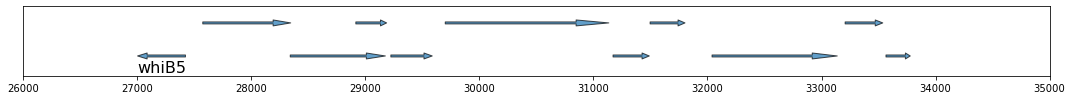

In [302]:
def plot_features(rec, ax, rows=3, xstart=0, xend=30000):
    
    h=1
    df = tools.records_to_dataframe([rec])    
    df = df[(df.feat_type!='region') & (df['feat_type']!='source')]
    df = df[(df.start>xstart) & (df.end<xend)]
    df['length'] = df.end-df.start
    y = list(range(1,rows)) * len(df)
    df['y'] = y[:len(df)]
    df['color'] = 'blue'
    df = df.fillna('')
    #print (df)  
    
    from matplotlib.collections import PatchCollection
    import matplotlib.patches as mpatches

    patches=[]
    for i,r in df.iterrows():        
        #rect = plt.Rectangle((r.start, r.y), r.length, h/2,
        #                        alpha=.5, linewidth=.5,
        #                        edgecolor='black', facecolor=r.color)
        if r.strand == 1:
            x = r.start
            dx = r.length
        else:
            x = r.end
            dx = -r.length
        arrow = mpatches.Arrow(x, r.y, dx, 0, alpha=.7, width=.3, 
                               edgecolor='black')
        txt = ax.text(r.start, r.y-h/2, r.gene, size=16)
        patches.append(arrow)  
        
    ax.add_collection(PatchCollection(patches, match_original=True))  
    ax.set_xlim(xstart, xend)
    ax.set_ylim(.4,rows-.5)
    plt.yticks([])
    plt.tight_layout()

    def onclick(event):
        print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
              ('double' if event.dblclick else 'single', event.button,
               event.x, event.y, event.xdata, event.ydata))
        ax.text(event.x, event.y, 'HI!')
        ax.figure.canvas.draw()
    #cid = ax.figure.canvas.mpl_connect('button_press_event', onclick)
    return

reload(tools)
recs = tools.gff_to_records(app.mbovis_gff)
rec=recs[0]
f,ax=plt.subplots(1,1,figsize=(15,1.5))
plot_features(rec, ax=ax, xstart=26000,xend=35000)

## replace pysam

In [352]:
def get_chrom(bam_file):
    """Get first sequence name in a bam file"""

    import pysam
    samfile = pysam.AlignmentFile(bam_file, "r")
    iter=samfile.fetch(start=0,end=10)
    for read in iter:
        if read.reference_name:
            return read.reference_name
        
get_chrom('mapped/3_S57_L001.bam')

'LT708304.1'

In [371]:
import bamnostic as bs
bam = bs.AlignmentFile('mapped/3_S57_L001.bam', 'rb')

In [372]:
chrom=bam.header['SQ'][0]['SN']

In [ ]:
for i, read in enumerate(bam.fetch(chrom, 1, 10)):
    print(read)

In [ ]:
def get_coverage(bam_file, chr, start, end):
    """Get coverage from bam file at specified region"""
    
    import bamnostic as bs
    if bam_file is None or not os.path.exists(bam_file):
        return
    bam = bs.AlignmentFile(bam_file, 'rb')
    for i, read in enumerate(bam.fetch(chrom, 1, 10)):
        print(read)
    return

get_coverage('mapped/3_S57_L001.bam', chrom, 1, 100)

In [25]:
def samtools_flagstats(filename):
    """Parse samtools flagstat output into dictionary"""
    
    cmd = 'samtools flagstat %s' %filename
    tmp = subprocess.check_output(cmd, shell=True, universal_newlines=True)
    x = tmp.split('\n')    
    x = [int(i.split('+')[0]) for i in x[:-1]]
    #print (x)
    cols = ['total','secondary','supplementary','duplicates','mapped',
            'paired','read1','read2','properly paired','with itself','singletons']
    d = {}
    for c,v in zip(cols,x):
        d[c] = v
    return d

samtools_flagstats('mapped/6_S7_L001.bam')

{'total': 1033927,
 'secondary': 4739,
 'supplementary': 0,
 'duplicates': 0,
 'mapped': 1033927,
 'paired': 1029188,
 'read1': 514963,
 'read2': 514225,
 'properly paired': 1019092,
 'with itself': 1027864,
 'singletons': 1324}